In [1]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np
import sys
import time

Matplotlib is building the font cache; this may take a moment.


In [2]:
region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
holidays_key = 'holidays_events.csv'
oil_key = 'oil.csv'

holiday = 's3://{}/{}/{}'.format(bucket, prefix, holidays_key)
oil = 's3://{}/{}/{}'.format(bucket, prefix, oil_key)

holidays = pd.read_csv(holiday)
oils = pd.read_csv(oil)

holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [3]:
len(oils.date.unique())

1218

In [4]:
df = pd.concat([oils, holidays])

df['date'] = pd.to_datetime(df['date'])

df

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,date,dcoilwtico,type,locale,locale_name,description,transferred
0,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,92.97,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,93.12,NaN,NaN,NaN,NaN,NaN
4,2013-01-07,93.20,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
345,2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,NaN,Holiday,National,Ecuador,Navidad,False


<AxesSubplot: xlabel='month', ylabel='dcoilwtico'>

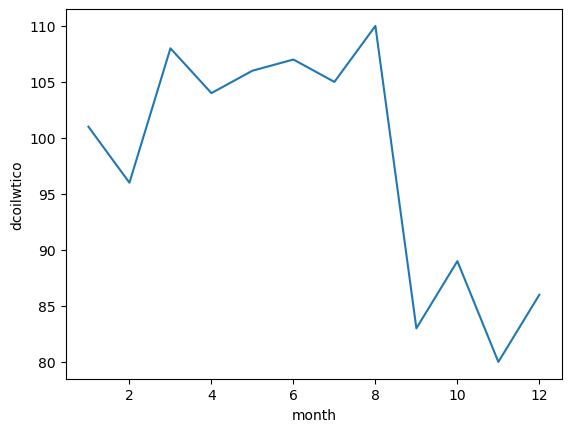

In [5]:
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df['day'] = pd.DatetimeIndex(df['date']).day

oil_by_month = df.groupby('month')['dcoilwtico'].count()

sns.lineplot(oil_by_month)

<AxesSubplot: xlabel='type', ylabel='count'>

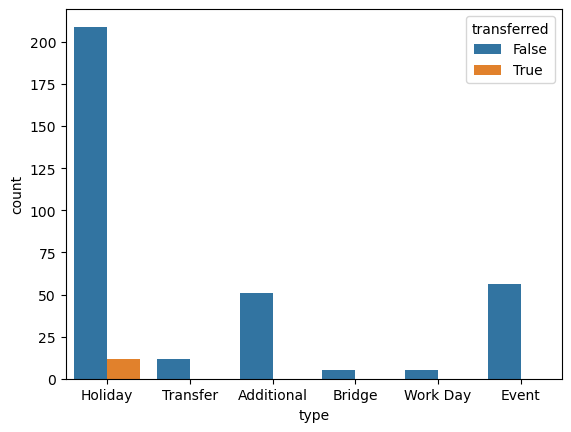

In [6]:
oil_by_month = df.groupby('type')['transferred'].count()

sns.countplot(data=df, x='type', hue='transferred')

<AxesSubplot: xlabel='locale', ylabel='count'>

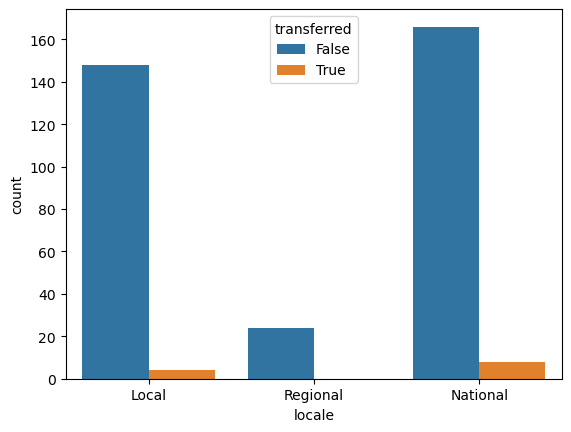

In [7]:
sns.countplot(data=df, x='locale', hue='transferred')

<AxesSubplot: xlabel='month', ylabel='transferred'>

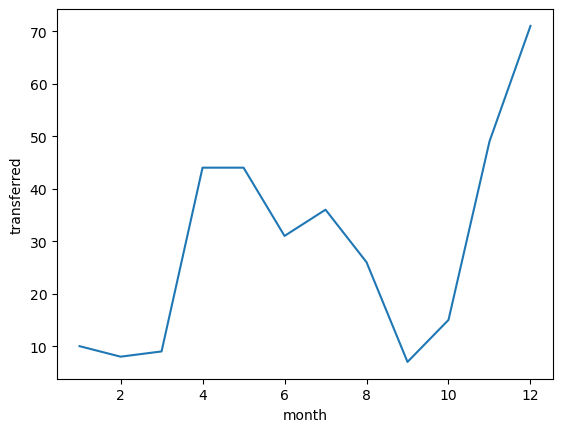

In [8]:
transfer_by_month = df.groupby('month')['transferred'].count()

sns.lineplot(transfer_by_month)

<AxesSubplot: xlabel='month', ylabel='type'>

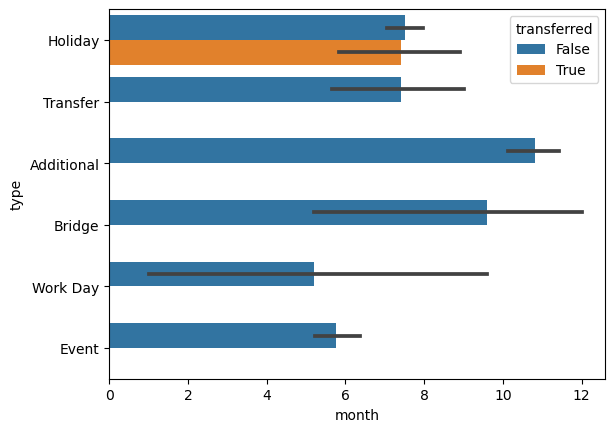

In [9]:
sns.barplot(data=df, x='month', y='type', hue='transferred')

<AxesSubplot: xlabel='day', ylabel='dcoilwtico'>

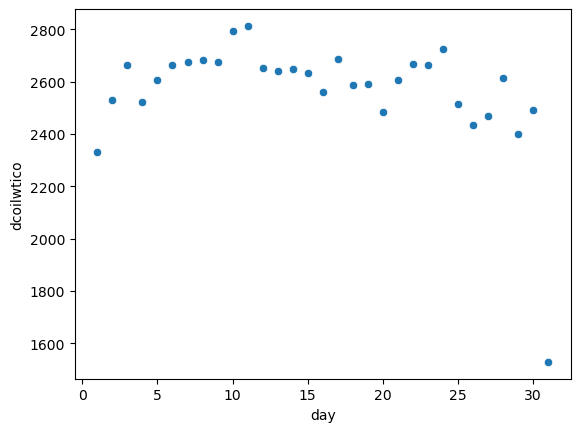

In [10]:
oil_by_day = df.groupby('day')['dcoilwtico'].sum()

sns.scatterplot(oil_by_day)

<AxesSubplot: xlabel='month', ylabel='dcoilwtico'>

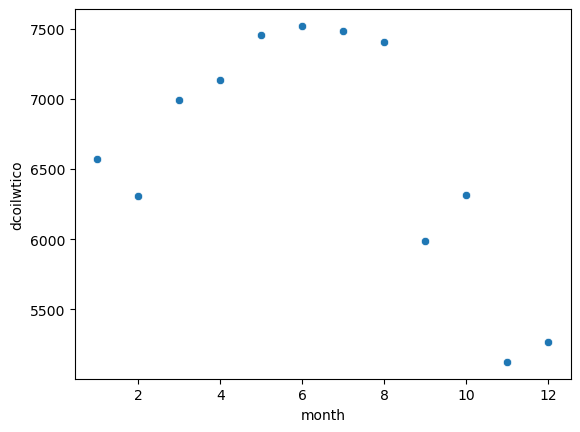

In [11]:
oil_by_month = df.groupby('month')['dcoilwtico'].sum()

sns.scatterplot(oil_by_month)

In [12]:
total_nan = len(df[df['dcoilwtico'].isna()])
percent_of_total = total_nan/ len(df)
percent_of_total

df

,date,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
0,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1
1,2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN,1,2013,2
2,2013-01-03,92.97,NaN,NaN,NaN,NaN,NaN,1,2013,3
3,2013-01-04,93.12,NaN,NaN,NaN,NaN,NaN,1,2013,4
4,2013-01-07,93.20,NaN,NaN,NaN,NaN,NaN,1,2013,7
...,...,...,...,...,...,...,...,...,...,...
345,2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
346,2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
347,2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24
348,2017-12-25,NaN,Holiday,National,Ecuador,Navidad,False,12,2017,25


In [13]:
# Large number of NaN means need to impute these somehow
# Not feasible to drop these as there are too many NaNs
# For numeric features will be using mean of the feature
# For categorical we will be using the mode

total_dcoil = df.dcoilwtico.sum()
len_set = len(df)
mean_of_dcoil = round((total_dcoil/len_set),3)

print(mean_of_dcoil)
df.loc[df['dcoilwtico'].isna(), 'dcoilwtico'] = mean_of_dcoil


types_mode = df['type'].value_counts().idxmax()
locale_mode = df['locale'].value_counts().idxmax()
locale_name_mode = df['locale_name'].value_counts().idxmax()
description_mode = df['description'].value_counts().idxmax()
transferred_mode = df['transferred'].value_counts().idxmax()

df.loc[df['type'].isna(), 'type'] = types_mode
df.loc[df['locale'].isna(), 'locale'] = locale_mode
df.loc[df['locale_name'].isna(), 'locale_name'] = locale_name_mode
df.loc[df['description'].isna(), 'description'] = description_mode
df.loc[df['transferred'].isna(), 'transferred'] = transferred_mode


df

50.743


,date,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
0,2013-01-01,50.743,Holiday,National,Ecuador,Carnaval,False,1,2013,1
1,2013-01-02,93.140,Holiday,National,Ecuador,Carnaval,False,1,2013,2
2,2013-01-03,92.970,Holiday,National,Ecuador,Carnaval,False,1,2013,3
3,2013-01-04,93.120,Holiday,National,Ecuador,Carnaval,False,1,2013,4
4,2013-01-07,93.200,Holiday,National,Ecuador,Carnaval,False,1,2013,7
...,...,...,...,...,...,...,...,...,...,...
345,2017-12-22,50.743,Additional,National,Ecuador,Navidad-3,False,12,2017,22
346,2017-12-23,50.743,Additional,National,Ecuador,Navidad-2,False,12,2017,23
347,2017-12-24,50.743,Additional,National,Ecuador,Navidad-1,False,12,2017,24
348,2017-12-25,50.743,Holiday,National,Ecuador,Navidad,False,12,2017,25


In [14]:
#Encoding the categorical variables using dummies

types = pd.get_dummies(df['type'])
locale = pd.get_dummies(df['locale'])
locale_name = pd.get_dummies(df['locale_name'])
#description = pd.get_dummies(df['description'])
transferred = pd.get_dummies(df['transferred'], drop_first=True)
#month = pd.get_dummies(df['month'], drop_first=True)
#year = pd.get_dummies(df['year'], drop_first=True)
#day = pd.get_dummies(df['day'], drop_first=True)

df = pd.concat([df, types], axis=1)
df = pd.concat([df, locale], axis=1)
df = pd.concat([df, locale_name], axis=1)
#df = pd.concat([df, description], axis=1)
df = pd.concat([df, transferred], axis=1)
#df = pd.concat([df, month], axis=1)
#df = pd.concat([df, year], axis=1)
#df = pd.concat([df, day], axis=1)

df = df.drop(['type', 'locale', 'locale_name', 'description', 'transferred','day', 'date'], axis=1)
df

,dcoilwtico,month,year,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
0,50.743,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,93.140,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,92.970,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93.120,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,93.200,1,2013,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,50.743,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346,50.743,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
347,50.743,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348,50.743,12,2017,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()

df.columns = df.columns.astype(str)

scaled = scale.fit_transform(df)

df = pd.DataFrame(scaled)

df

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.290809,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.792965,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.790951,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.792728,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.793675,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,0.290809,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,0.290809,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1565,0.290809,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1566,0.290809,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#f = io.BytesIO()
#smac.write_numpy_to_dense_tensor(f, train_X.astype("float32"), train_y.astype("float32"))
#f.seek(0)

#boto3.Session().resource("s3").Bucket(bucket).Object(
#    os.path.join(prefix, "train", train_file)
#).upload_fileobj(f)

train_data, validation_data, test_data = np.split(
    df.sample(frac=1, random_state=1729),
    [int(0.7 * len(df)), int(0.9 * len(df))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

train_data

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
182,0.977496,0.727273,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1342,0.290809,0.545455,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,0.307237,0.090909,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.796163,0.181818,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.848869,0.636364,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.855265,1.000000,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1484,0.290809,0.545455,0.8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1297,0.290809,0.909091,0.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278,0.834656,0.000000,0.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
bucket

'sagemaker-eu-west-2-866647877267'

In [18]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator


#container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")


container = image_uris.retrieve('linear-learner', region)


sm = boto3.client("sagemaker")

ll_estimator = Estimator(container, 
                        role=role,
                        instance_count=1,
                        instance_type='ml.m5.large',
                        output_path='s3://{}/{}/output'.format(bucket, prefix))
                         
ll_estimator.set_hyperparameters(predictor_type='regressor')

In [ ]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="text/csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="text/csv"
)

ll_data = {'train' : s3_input_train, 'validation' : s3_input_validation}

ll_estimator.fit(ll_data)

INFO:sagemaker:Creating training-job with name: linear-learner-2023-03-20-12-03-47-393


2023-03-20 12:03:47 Starting - Starting the training job...
2023-03-20 12:04:02 Starting - Preparing the instances for training......
2023-03-20 12:04:49 Downloading - Downloading input data...
2023-03-20 12:05:30 Training - Downloading the training image......
2023-03-20 12:06:41 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/20/2023 12:06:46 INFO 139895656941376] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': '


2023-03-20 12:07:12 Uploading - Uploading generated training model
2023-03-20 12:07:12 Completed - Training job completed
Training seconds: 143
Billable seconds: 143


In [ ]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.06",
          "MinValue": "0.01",
          "Name": "wd"
        },
        {
          "MaxValue": "0.08",
          "MinValue": "0.01",
          "Name": "learning_rate"
        },
        {
          "MaxValue": "0.08",
          "MinValue": "0.001",
          "Name": "l1"
        },
      ],
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 10,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
        "MetricName": "validation:mse",
        "Type": "Minimize",
    },
    "RandomSeed" : 123
  }

In [ ]:
linear_job = "CHALLE-RUN" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", linear_job)

s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "text/csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "text/csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
        "predictor_type" : "regressor"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}


Job name is: CHALLE-RUN2023-03-20-12-07-31


In [ ]:
linear_job = "DEMO-linear-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", linear_job)

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.c4.2xlarge", "VolumeSizeInGB": 10},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                    "S3DataDistributionType": "ShardedByS3Key",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "HyperParameters": {
        "feature_dim": "183",
        "predictor_type": "regressor",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Job name is: DEMO-linear-2023-03-20-12-07-31


In [47]:
from time import strftime, gmtime
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'linear-learner-' + timestamp

print(endpoint_name)

ll_predictor = ll_estimator.deploy(endpoint_name=endpoint_name,
                                  initial_instance_count=1,
                                  instance_type='ml.t2.medium',
                                  serializer=CSVSerializer(),
                                  deserializer=CSVDeserializer())

INFO:sagemaker:Creating model with name: linear-learner-2023-03-19-15-01-41-038


linear-learner-19-15-01-41


INFO:sagemaker:Creating endpoint-config with name linear-learner-19-15-01-41
INFO:sagemaker:Creating endpoint with name linear-learner-19-15-01-41


--------------!

In [62]:
def predict(data, rows=155):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    print(split_array)
    predictions = []
    for array in split_array:
        print(array)
        #predictions = "".join([predictions, ll_predictor.predict(array)])
        predictions.append(ll_predictor.predict(array))

    return predictions


predictions = predict(test_data.values[:, 1:])
predictions

[array([[0.18181818, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09090909, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.45454545, 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63636364, 0.6       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.27272727, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.63636364, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]), array([[0.27272727, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.81818182, 0.8       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.36363636, 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.27272727, 0.2       , 0

[[['0.20594102144241333'],
  ['0.6784481406211853'],
  ['0.5618484020233154'],
  ['0.20908820629119873'],
  ['0.32476213574409485'],
  ['0.20408940315246582'],
  ['0.5710284113883972'],
  ['0.3256879448890686'],
  ['-0.005617499351501465'],
  ['0.5605528354644775'],
  ['0.6719674468040466'],
  ['0.2068668007850647'],
  ['0.6756706833839417'],
  ['0.4380284249782562'],
  ['0.6710416674613953'],
  ['0.43988004326820374'],
  ['0.7161910533905029'],
  ['0.23470807075500488'],
  ['0.32291051745414734'],
  ['0.44358327984809875'],
  ['0.6691900491714478'],
  ['0.32476213574409485'],
  ['0.20594102144241333'],
  ['0.5587011575698853'],
  ['0.3256879448890686'],
  ['0.31920725107192993'],
  ['0.5549979209899902'],
  ['0.5559237599372864'],
  ['0.21666386723518372'],
  ['0.31642982363700867'],
  ['-0.07870662212371826'],
  ['0.6756706833839417'],
  ['0.5577753782272339'],
  ['0.44358327984809875'],
  ['0.2050151824951172'],
  ['0.6691900491714478'],
  ['0.5596269965171814'],
  ['0.3238363265991

Mean squared error is  0.049053011190843064
R^2 is  0.39829366024789614


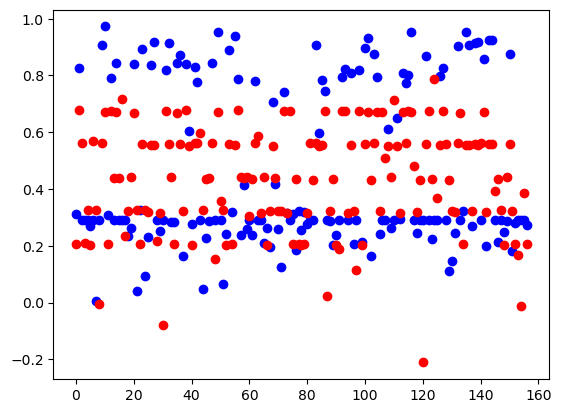

In [63]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

predictions
flat_list = [item for sublist in predictions for item in sublist]

predicted = np.array(flat_list, dtype=float)
actual = test_data[0]
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)
print("Mean squared error is ", mse)
print("R^2 is ", r2)

actual.shape
predicted = predicted.reshape(157,)

plt.scatter(range(len(actual)), actual, color='blue')
plt.scatter(range(len(predicted)), predicted, color='red')

difference = actual - predicted

In [24]:
tuning_job_name = "CHALLE-OIL-TUNE"
sm.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                          HyperParameterTuningJobConfig = tuning_job_config,
                                          TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:hyper-parameter-tuning-job/challe-oil-tune',
 'ResponseMetadata': {'RequestId': '8331ccab-b9c6-4bd2-9ccf-f2f52ed795ac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8331ccab-b9c6-4bd2-9ccf-f2f52ed795ac',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '116',
   'date': 'Mon, 20 Mar 2023 12:09:53 GMT'},
  'RetryAttempts': 0}}

In [25]:
best_overall_training_job = sm.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)["BestTrainingJob"]

best_overall_training_job

{'TrainingJobName': 'CHALLE-OIL-TUNE-004-7f651333',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:training-job/CHALLE-OIL-TUNE-004-7f651333',
 'CreationTime': datetime.datetime(2023, 3, 20, 12, 13, 17, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 3, 20, 12, 13, 29, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 3, 20, 12, 14, 1, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'l1': '0.002458954961358549',
  'learning_rate': '0.03040893934986613',
  'wd': '0.059781159422445'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mse',
  'Value': 0.0388948954641819},
 'ObjectiveStatus': 'Succeeded'}